In [1]:
import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
import os
######################Parameter#################################
topK = 20 
testRate = 0.2
seed = 2
##########################################################

# All the data could be downloaded from: https://1drv.ms/f/s!Ao2ItRTtXaxehiA2DdroBpFMIqL_

#フォルダ
dataDir = '/Users/hayden/Documents/data'#フォルダ

In [2]:
#データを読み取る
users = pd.read_table(dataDir+'/ml-100k/u.user',sep="|",names=['user_id','age','sex','occupation','zip_code'],encoding='latin-1',engine='python')
ratings = pd.read_table(dataDir+'/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1',engine='python')
movies = pd.read_table(dataDir+'/ml-100k/u.item',engine='python', sep='|',header=None,encoding='latin-1',names=['movie_id','title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']) 
movies = movies.iloc[:,:5]
#インデックスの設定
users = users.set_index(['user_id'],drop=False)
movies = movies.set_index(['movie_id'],drop=False)
ratings = ratings.set_index(['user_id','movie_id'],drop=False) 

In [3]:
users.head()

,user_id,age,sex,occupation,zip_code
user_id,,,,,
1,1,24,M,technician,85711
2,2,53,F,other,94043
3,3,23,M,writer,32067
4,4,24,M,technician,43537
5,5,33,F,other,15213


In [4]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL
movie_id,,,,,
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
2,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
3,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
4,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
5,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [5]:
ratings.head()

,,user_id,movie_id,rating,unix_timestamp
user_id,movie_id,,,,
196,242,196,242,3,881250949
186,302,186,302,3,891717742
22,377,22,377,1,878887116
244,51,244,51,2,880606923
166,346,166,346,1,886397596


In [6]:
#　Rating データをテストとトレーニングデータに分ける
np.random.seed(seed)
testIndex = np.random.choice(range(ratings.shape[0]),size=int(ratings.shape[0]*testRate),replace=False)
testRatings = ratings.iloc[testIndex,:]
trainIndex = list(set(range(ratings.shape[0]))-set(testIndex))
trainRatings = ratings.iloc[trainIndex,:]

In [7]:
# トレーニングセットで見られた全ての映画のユーザidを集計します
def calUsers(movieId):
    # user-movieデータ
    try:
        views = trainRatings.loc[(slice(None),movieId),:]
    except:
        return []
    users = views['user_id'].values.tolist()
    return users
movies['users'] = movies['movie_id'].apply(calUsers)
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,users
movie_id,,,,,,
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[308, 287, 148, 280, 66, 109, 181, 95, 189, 14..."
2,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[5, 268, 276, 87, 250, 201, 64, 13, 213, 373, ..."
3,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,"[181, 81, 130, 49, 320, 145, 95, 99, 267, 417,..."
4,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[99, 19, 207, 295, 201, 10, 308, 328, 109, 334..."
5,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[293, 43, 311, 109, 344, 145, 314, 308, 280, 4..."


In [8]:

#　全てのユーザーがトレーニングセットで見た映画idを集計します
def calMovies(userId):
    #　user-movieデータ
    try:
        views = trainRatings.loc[(userId,slice(None)),:]
    except:
        return []
    movies = views['movie_id'].values.tolist()
    return movies
users['movies'] = users['user_id'].apply(calMovies)
users.head()

,user_id,age,sex,occupation,zip_code,movies
user_id,,,,,,
1,1,24,M,technician,85711,"[61, 189, 33, 160, 20, 202, 171, 265, 117, 47,..."
2,2,53,F,other,94043,"[292, 251, 314, 297, 312, 281, 13, 303, 308, 2..."
3,3,23,M,writer,32067,"[335, 245, 337, 343, 323, 331, 294, 332, 334, ..."
4,4,24,M,technician,43537,"[264, 303, 361, 357, 260, 356, 294, 288, 50, 2..."
5,5,33,F,other,15213,"[2, 439, 225, 110, 454, 424, 363, 98, 102, 211..."


類似度行列を計算し、最初の5行5列の要素、すなわち各ユーザ間の類似度を調べます。

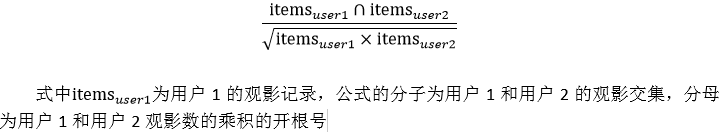

In [9]:
#類似度行列を計算し
sims = pd.DataFrame(0,columns=users.index,index=users.index)
def calSim(userId1,userId2):
    #ユーザ1の映画
    user1Items = users.loc[userId1,'movies']
    #ユーザ2の映画
    user2Items = users.loc[userId2,'movies']
    #共通アイテムです
    cross = list(set(user1Items) & set(user2Items))
    #類似度
    sim = len(cross)/((max(1e-1,len(user1Items))*max(1e-1,len(user2Items)))**0.5)
    return sim 
def fillSims(row):
    userIds = pd.Series(row.index)
    row[:] = userIds.apply(calSim,args=(row.name,))
    return row
sims = sims.apply(fillSims,axis=1)
sims.iloc[:5,:5]

user_id,1,2,3,4,5
user_id,,,,,
1,1.000000,0.116008,0.069067,0.064449,0.275500
2,0.116008,1.000000,0.142887,0.133333,0.036380
3,0.069067,0.142887,1.000000,0.238145,0.012377
4,0.064449,0.133333,0.238145,1.000000,0.040423
5,0.275500,0.036380,0.012377,0.040423,1.000000


In [10]:
#近隣のユーザーを計算します
def calNearUsers(userId):
    #そのモノの類似度ベクトル、topK個のモノを選びます。
    nearUserIds = sims.loc[:,userId].sort_values(ascending=False)[1:topK+1]
    nearUserIds = nearUserIds.index.tolist()
    return nearUserIds
users['near'] = users['user_id'].apply(calNearUsers)
users.head()

,user_id,age,sex,occupation,zip_code,movies,near
user_id,,,,,,,
1,1,24,M,technician,85711,"[61, 189, 33, 160, 20, 202, 171, 265, 117, 47,...","[457, 435, 916, 648, 933, 276, 864, 297, 805, ..."
2,2,53,F,other,94043,"[292, 251, 314, 297, 312, 281, 13, 303, 308, 2...","[701, 673, 926, 131, 306, 569, 937, 520, 486, ..."
3,3,23,M,writer,32067,"[335, 245, 337, 343, 323, 331, 294, 332, 334, ...","[752, 489, 784, 587, 863, 529, 783, 428, 126, ..."
4,4,24,M,technician,43537,"[264, 303, 361, 357, 260, 356, 294, 288, 50, 2...","[33, 816, 750, 408, 443, 783, 725, 596, 355, 6..."
5,5,33,F,other,15213,"[2, 439, 225, 110, 454, 424, 363, 98, 102, 211...","[222, 648, 407, 56, 495, 254, 497, 457, 727, 1..."


テストセットのスコアを予測し、最終テストMAEは0.84でした。式は次のようになります。

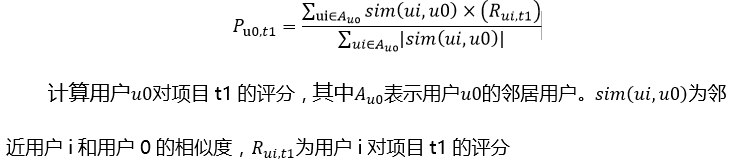

In [11]:
def predict(row):
    '''スコアの予測'''
    userId = row['user_id']
    movieId = row['movie_id']
    #topK個近隣ユーザ
    nearUserIds = users.loc[userId,'near']
    #映画を見たことあるユーザ
    itemUserIds = movies.loc[movieId,'users']
    #cross
    cross = list(set(nearUserIds) & set(itemUserIds))        
    #スコアの予測
    up = 0#分母
    down = 0#分子
    for nearUserId in cross:
        sim = sims.loc[nearUserId,userId]
        down += sim
        #近隣ユーザでのスコア
        score = trainRatings.loc[(nearUserId,movieId),'rating']
        up += score * sim
    if up == 0:
        return None
    else:
        return up/down
    
#テストセット
testRatings['predict'] = testRatings.apply(predict,axis=1)
testRatings = testRatings.dropna()
mae = MAE(testRatings['rating'],testRatings['predict'])
print('テストセットのMAEは%.2f'%mae)
testRatings.head()

テストセットのMAEは0.84


/var/folders/zx/jbzrrd8j4pjbnl10k80wqwhh0000gn/T/ipykernel_62159/106164976.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testRatings['predict'] = testRatings.apply(predict,axis=1)


,,user_id,movie_id,rating,unix_timestamp,predict
user_id,movie_id,,,,,
157,273,157,273,5,886889876,3.740361
405,1065,405,1065,1,885546069,3.790151
244,550,244,550,1,880602264,3.164083
378,768,378,768,4,880333598,2.786181
919,111,919,111,4,875288681,3.691650
